# Map Visualisierung

Diese Visualisierung liest die Daten der DynamoDB ein und visualisiert die Fälle auf einer Karte.

In [10]:
# Imports

import os
import descartes
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Config

plt.style.use('seaborn')

dir = "."
input_filename = "SimLakeInput.csv"
output_filename = "Prozentuale Verteilung Coronavirus.pdf"

# Calculated Fields

dataDir = os.path.abspath(dir)
input = dataDir + "/" + input_filename

print("Reading from " + input)

Reading from /Users/jonathanhasenburg/git/cov-erage/analytics/SimLakeInput.csv


### Einlesen und verarbeiten der DynamoDB Daten

Wir ermitteln wie viele Menschen vermuten am Coronavirus erkrankt zu sein, sowie wie viele wissen, dass sie 
am Coronoavirus erkrankt sind für jede Postleitzahl.

In [11]:
#Read in DynamoDB data
df_dynamo = pd.read_csv(input, delimiter=",", dtype={'postalCode': str})
df_dynamo.head()

,gender,coronaVirus,postalCode,loneliness,diarrhea,userId,insomnia,limbPain,coughing,generalHealth,soreThroat,temperature,runnyNose,headache,id,numberOfContacts,timestamp,yearOfBirth,Unnamed: 18
0,2,5,79589,5,1,Titian,"2,""3",2,3,2,1,2,2,063-89-8674,342,1584882145503,1960,NaN,NaN
1,2,1,24113,2,2,Magritte,"5,""2",2,5,2,1,2,2,661-19-5038,572,1584882145508,1957,NaN,NaN
2,2,1,85764,5,1,Picasso,"4,""2",2,3,1,2,2,1,612-25-8824,940,1584882145511,1993,NaN,NaN
3,2,1,99095,3,2,Vettriano,"3,""2",2,3,1,2,2,2,091-84-8858,437,1584882145515,1977,NaN,NaN
4,1,5,56271,4,2,Durer,"3,""3",2,2,1,2,1,3,607-38-2419,909,1584882145518,1986,NaN,NaN


In [12]:
# Drop not needed fields
df_cg1 = df_dynamo.drop(columns = ["id","timestamp", "coughing","diarrhea","gender",
                                   "generalHealth","headache","insomnia","limbPain","loneliness",
                                   "numberOfContacts","runnyNose","soreThroat",
                                   "temperature","userId","yearOfBirth"])

# Create a column for yes (think so and confirmed) and no (no, I do not know, I recovered)
df_cg1["yes"] = np.where((df_cg1["coronaVirus"]==2) | (df_cg1["coronaVirus"] == 3), 1, 0)
df_cg1["no"] = np.where((df_cg1["coronaVirus"]==1) | (df_cg1["coronaVirus"] == 4) | (df_cg1["coronaVirus"] == 5), 1, 0)

df_cg1.head(10)

,coronaVirus,postalCode,Unnamed: 18,yes,no
0,5,79589,NaN,0,1
1,1,24113,NaN,0,1
2,1,85764,NaN,0,1
3,1,99095,NaN,0,1
4,5,56271,NaN,0,1
5,1,06888,NaN,0,1
6,5,82390,NaN,0,1
7,1,16727,NaN,0,1
8,1,83553,NaN,0,1
9,1,88637,NaN,0,1


In [13]:
# Aggregate for each postal code
df_cg2a = df_cg1.groupby(["postalCode"])["yes"].sum().reset_index()
df_cg2b = df_cg1.groupby(["postalCode"])["no"].sum().reset_index()
df_cg2 = df_cg2a.merge(df_cg2b)

# Calculate percentage
df_cg2["percentage"] = df_cg2["yes"] / (df_cg2["no"] + df_cg2["yes"])
df_cg2["plz"] = df_cg2["postalCode"].astype(str)

# Drop not needed column
df_cg2.drop(columns=["postalCode"], inplace=True)

df_cg2

,yes,no,percentage,plz
0,4,131,0.029630,01067
1,8,221,0.034934,01069
2,12,118,0.092308,01097
3,4,99,0.038835,01099
4,4,90,0.042553,01108
5,7,104,0.063063,01109
6,11,221,0.047414,01127
7,6,99,0.057143,01129
8,0,115,0.000000,01139
9,7,111,0.059322,01156


In [14]:
# show which postal codes have max percentage of cases
df_cg2.nlargest(10, ['percentage'])

,yes,no,percentage,plz
2648,37,84,0.305785,36466
5737,29,71,0.290000,79238
3169,34,86,0.283333,45476
5391,30,77,0.280374,74915
5379,28,78,0.264151,74855
2638,31,87,0.262712,36399
5376,30,86,0.258621,74842
5739,30,86,0.258621,79244
2633,29,85,0.254386,36367
2993,29,85,0.254386,41352


### Vorbereitung der Kartendaten

Die Visualisierung basiert auf folgenden Blogpost, viel Code wurde übernommen: https://www.kdnuggets.com/2020/01/open-data-germany-maps-viz.html

In [15]:
# Read PLZ polygons
# Make sure you read postal codes as strings, otherwise 
# the postal code 01110 will be parsed as the number 1110. 
plz_shape_df = gpd.read_file('plz-gebiete/plz-gebiete.shp', dtype={'plz': str})
# plz_shape_df["plz"].to_csv("Postleitzahlen.csv")
plz_shape_df.head(5)

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


In [16]:
# Define cities to plot (makes it easier to understand map)
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Köln': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'München': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nürnberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

print("Using cities " + str(top_cities))

Using cities {'Berlin': (13.404954, 52.520008), 'Köln': (6.953101, 50.935173), 'Düsseldorf': (6.782048, 51.227144), 'Frankfurt am Main': (8.682127, 50.110924), 'Hamburg': (9.993682, 53.551086), 'Leipzig': (12.387772, 51.343479), 'München': (11.576124, 48.137154), 'Dortmund': (7.468554, 51.5134), 'Stuttgart': (9.181332, 48.777128), 'Nürnberg': (11.077438, 49.44982), 'Hannover': (9.73322, 52.37052)}


In [17]:
# Merge plz_df and Coverage lake.
merged_cg2 = pd.merge(
    left=plz_shape_df, 
    right=df_cg2,
    on="plz",
    how='left'
)
merged_cg2.fillna(0, inplace=True)

merged_cg2.head()

,plz,note,geometry,yes,no,percentage
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",8,111,0.067227
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",4,91,0.042105
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",7,131,0.050725
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ...",5,113,0.042373
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ...",4,114,0.033898


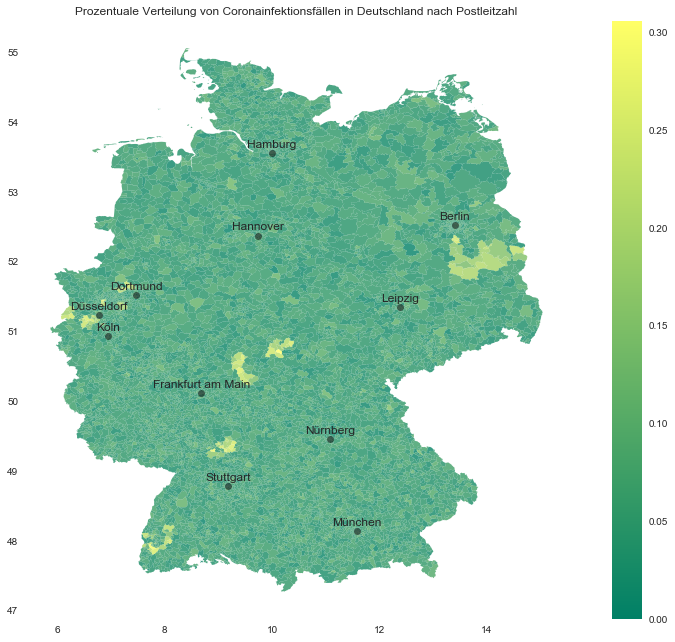

In [18]:
#Plot
plt.rcParams['figure.figsize'] = [16, 11]
fig, ax = plt.subplots()

#plot plz shape
merged_cg2.plot(
    ax=ax, 
    column='percentage', 
    categorical=False, 
    legend=True, 
    cmap='summer',
    alpha=0.8
)

#plot cities
for c in top_cities.keys():
    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Prozentuale Verteilung von Coronainfektionsfällen in Deutschland nach Postleitzahl', 
    aspect=1.3,
    facecolor='white'
);

fig.savefig(output_filename)